In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, classification_report
#warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
#Importando os dados
dados = pd.read_csv("dados_coletados80k.csv")

In [5]:
#Analisando o tamanho dos dados
dados.shape

(80143, 24)

In [7]:
#Visualizacao dos dados
dados.head()

,Contrato,Idade,Sexo,Valor_Renda,UF_Cliente,Perc_Juros,Prazo_Emprestimo,Data_Contratacao,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Escolaridade,Possui_Patrimonio,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago,Possivel_Fraude
0,322090928715,42,M,4000.00,MA,17.00,140,2022-11-18,143,160000.00,184000.00,2,1,1,2,SOLTEIRO(A),NaN,N,0.00,10,284.00,187861.70,1617.36,Sim
1,321990634715,31,M,3000.00,MA,20.00,28,2021-07-23,0,14000.00,16100.00,2,1,1,1,CASADO (A),NaN,N,0.00,26,771.00,16615.93,1239.98,Sim
2,321965373715,36,F,2100.00,SP,24.00,180,2021-04-01,149,60000.00,69000.00,4,1,0,1,CASADO (A),Nenhum,N,0.00,27,802.00,74443.40,1346.64,Sim
3,321967133715,28,M,2155.00,DF,19.00,190,2021-04-10,159,180000.00,207000.00,29,28,0,2,SOLTEIRO(A),Nenhum,N,0.00,2,41.00,196812.41,22713.63,Nao
4,322098744715,21,F,4300.00,MG,22.00,100,2022-12-28,94,30000.00,34500.00,4,3,0,1,SOLTEIRO(A),Ensino Médio,N,0.00,6,162.00,36114.39,900.80,Sim


In [5]:
#Verificar se existe valores nulos
dados.isnull().sum()


Contrato                                0
Idade                                   0
Sexo                                    0
Valor_Renda                             0
UF_Cliente                              0
Perc_Juros                              0
Prazo_Emprestimo                        0
Data_Contratacao                        0
Prazo_Restante                          0
VL_Emprestimo                           0
VL_Emprestimo_ComJuros                  0
QT_Total_Parcelas_Pagas                 0
QT_Total_Parcelas_Pagas_EmDia           0
QT_Total_Parcelas_Pagas_EmAtraso        0
Qt_Renegociacao                         0
Estado_Civil                            0
Escolaridade                        57298
Possui_Patrimonio                       0
VL_Patrimonio                           0
QT_Parcelas_Atraso                      0
QT_Dias_Atraso                      25795
Saldo_Devedor                           0
Total_Pago                              0
Possivel_Fraude                   

Apenas a escolaridade e a quantidade de dias em atraso possuem dados nulos, porém na escolaridade são 57298 da fatantes, cerca de 71% dos dados são nulos, por isso a melhor estratégia seria não utilizar essa coluna para a analise de predição.

In [7]:
#Avaliando os dados de quantidade de dias em atraso para correção dos valores nulos 
dados["QT_Dias_Atraso"].describe()

count   54348.00
mean      475.26
std       269.79
min        11.00
25%       284.00
50%       468.00
75%       708.00
max      1014.00
Name: QT_Dias_Atraso, dtype: float64

E possível observar que a média e a mediana tem valores bem próximos, o que é um indício que não possui outlier muito discrepantes 

In [9]:
#Substituindo os dados NA pela mediana 
dados["QT_Dias_Atraso"] = dados["QT_Dias_Atraso"].fillna(468.00)
dados["QT_Dias_Atraso"].isnull().sum()

0

Agora vamos observar se os dados possuem alguma incompatibilidade 

In [11]:
#Avaliar as variaveis categoricas 
dados.groupby("Sexo").size()

Sexo
F    31643
M    48500
dtype: int64

In [13]:
dados.groupby("UF_Cliente").size()

UF_Cliente
AC       25
AL      867
AM       76
AP       23
BA     6709
CE     2050
DF      583
ES      312
GO     3860
MA     3593
MG    13718
MS     2120
MT      984
PA     3443
PB     1442
PE     2502
PI      731
PR     5794
RJ     2462
RN      759
RO       55
RR       15
RS     3500
SC     2555
SE      415
SP    21393
TO      157
dtype: int64

In [15]:
dados.groupby("Estado_Civil").size() 

Estado_Civil
CASADO (A)                23576
DIVORCIADO                 3783
NENHUM                        4
OUTRO                      5912
SEPARADO JUDICIALMENTE        4
SOLTEIRO(A)               45205
UNIÃO ESTAVEL               501
VIÚVO(A)                   1158
dtype: int64

In [17]:
dados['Estado_Civil'] = dados['Estado_Civil'].replace(['NENHUM'], 'OUTRO')
dados['Estado_Civil'] = dados['Estado_Civil'].replace(['SEPARADO JUDICIALMENTE'], 'DIVORCIADO')
dados.groupby("Estado_Civil").size() 

Estado_Civil
CASADO (A)       23576
DIVORCIADO        3787
OUTRO             5916
SOLTEIRO(A)      45205
UNIÃO ESTAVEL      501
VIÚVO(A)          1158
dtype: int64

In [19]:
dados.groupby("Possui_Patrimonio").size()

Possui_Patrimonio
N    79785
S      358
dtype: int64

In [21]:
dados.groupby("Possivel_Fraude").size()

Possivel_Fraude
Nao    35632
Sim    44511
dtype: int64

Na distribuição de Idade é possível verificas que possui dados incorretos, pois existe um cliente com 4 anos de idade e um de 103, 
o que mostra um provável erro de inserção de dados.

In [23]:
# pessoas até os 10 anos e acima de 90 são dados inseridos erroneamente
dados.groupby("Idade").size() 

Idade
4         2
6         1
7         1
8         1
9         1
10        1
17       12
18       60
19      424
20     1065
21     1533
22     1688
23     2059
24     2047
25     2310
26     2516
27     2431
28     2641
29     2652
30     2591
31     2512
32     2532
33     2429
34     2493
35     2577
36     2596
37     2333
38     2340
39     2301
40     2214
41     2325
42     2078
43     1997
44     2056
45     1831
46     1691
47     1503
48     1386
49     1366
50     1202
51     1293
52     1056
53     1060
54      977
55      934
56      825
57      781
58      772
59      733
60      716
61      558
62      533
63      470
64      418
65      364
66      379
67      308
68      312
69      332
70      285
71      226
72      148
73      210
74      112
75       93
76       95
77       63
78       59
79       37
80       46
81       33
82       30
83       24
84       19
85       11
86        9
87        5
88        7
89        3
90        3
91        1
92        1
94        

Uma forma eficiênte para resolver isso é criando uma faixa etária 

In [25]:
#construi a faixa etária a partir dos quartis 
bins = [0, 29, 37, 46, 103]
labels = ['Até 29 Anos', 'De 29 até 37 Anos', 'De 37 até 46 Anos', 'Acima de 46 Anos']
dados['Faixa_Etaria'] = pd.cut(dados['Idade'], bins=bins, labels=labels)
dados.groupby(['Faixa_Etaria']).size()

C:\Users\Darven Lima\AppData\Local\Temp\ipykernel_101812\1299281246.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dados.groupby(['Faixa_Etaria']).size()


Faixa_Etaria
Até 29 Anos          21445
De 29 até 37 Anos    20063
De 37 até 46 Anos    18833
Acima de 46 Anos     19802
dtype: int64

In [27]:
dados.describe()

,Contrato,Idade,Valor_Renda,Perc_Juros,Prazo_Emprestimo,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago
count,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00
mean,322023695416.17,38.82,29308.62,19.49,102.33,93.28,72847.78,83774.94,10.71,5.24,2.34,1.30,1.45,10.65,472.92,78622.32,9687.98
std,44697010.94,12.53,2748166.27,3.56,62.32,70.64,87407.93,100519.12,9.31,6.21,3.97,1.27,355.10,10.43,222.20,102318.95,19090.62
min,321944855715.00,4.00,0.00,4.49,14.00,-18.00,3000.00,3450.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,0.00
25%,321984967215.00,29.00,2050.00,18.00,55.00,36.00,15000.00,17250.00,2.00,1.00,0.00,0.00,0.00,0.00,376.00,12122.76,1052.16
50%,322024156715.00,37.00,3000.00,20.00,80.00,78.00,40000.00,46000.00,8.00,2.00,1.00,1.00,0.00,9.00,468.00,35489.36,3951.39
75%,322062662215.00,46.00,5000.00,21.00,170.00,156.00,100000.00,115000.00,18.00,7.00,3.00,2.00,0.00,20.00,589.00,117783.25,10886.24
max,322099706715.00,103.00,765000000.00,28.00,240.00,227.00,500000.00,575000.00,66.00,66.00,31.00,38.00,100000.00,34.00,1014.00,626261.27,465821.39


In [29]:
variaveis_numericas = []
for i in dados.columns[3:23].tolist():
        if dados.dtypes[i] == 'int64' or dados.dtypes[i] == 'float64':                        
            variaveis_numericas.append(i)  
variaveis_numericas

['Valor_Renda',
 'Perc_Juros',
 'Prazo_Emprestimo',
 'Prazo_Restante',
 'VL_Emprestimo',
 'VL_Emprestimo_ComJuros',
 'QT_Total_Parcelas_Pagas',
 'QT_Total_Parcelas_Pagas_EmDia',
 'QT_Total_Parcelas_Pagas_EmAtraso',
 'Qt_Renegociacao',
 'VL_Patrimonio',
 'QT_Parcelas_Atraso',
 'QT_Dias_Atraso',
 'Saldo_Devedor',
 'Total_Pago']

In [40]:
len(variaveis_numericas)

15

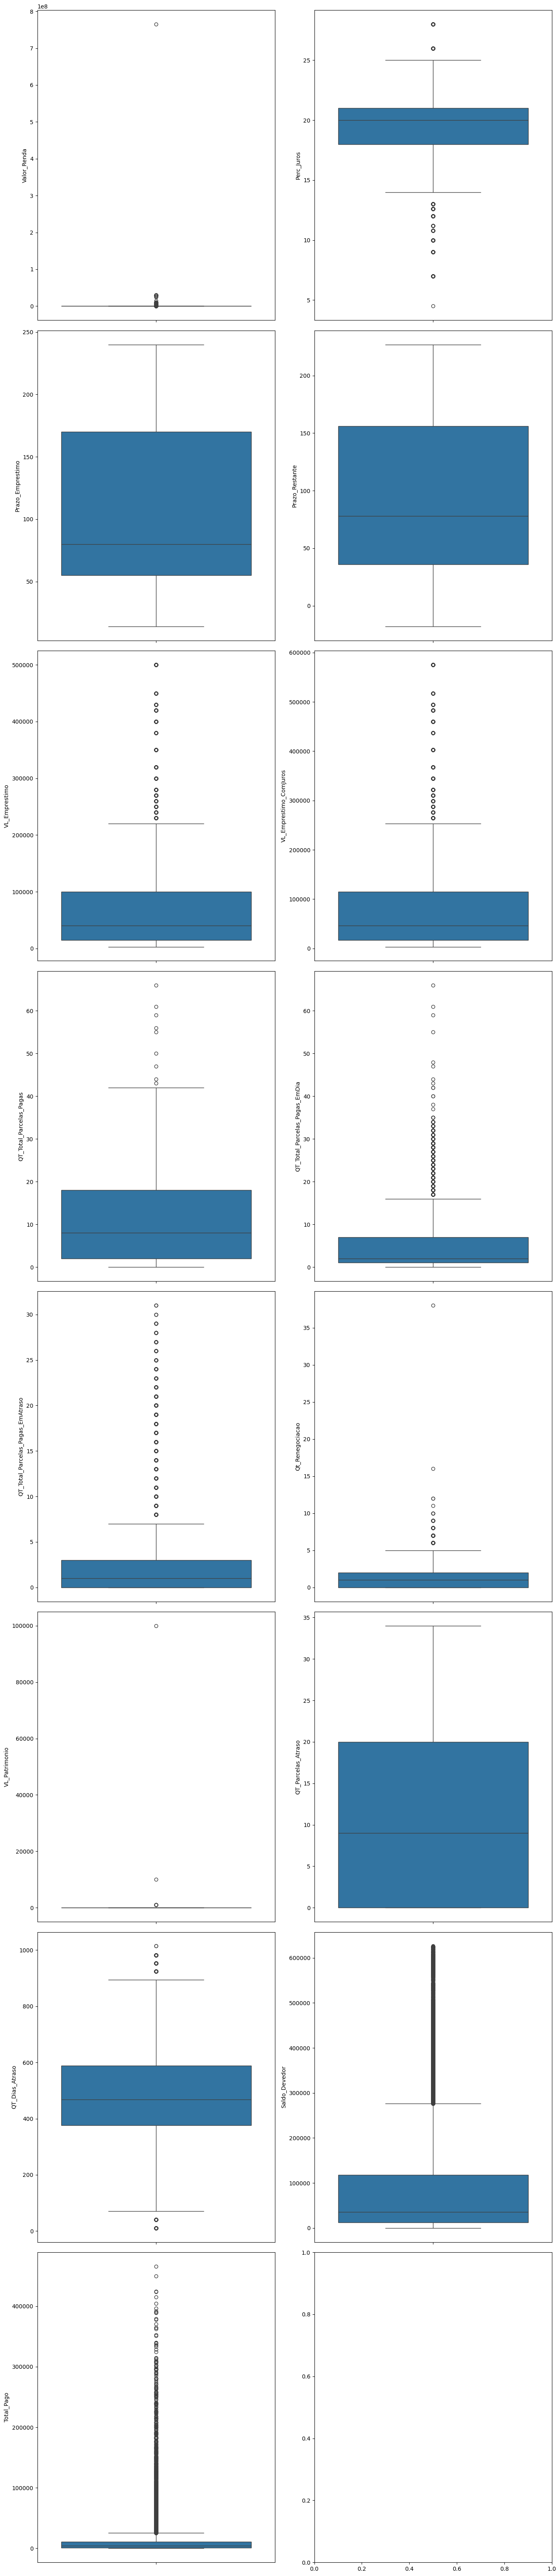

In [31]:
plt.rcParams["figure.figsize"] = [14.00, 64.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(8, 2) #5 linhas e 2 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = dados, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 2:
        linha += 1
        coluna = 0 

Os dados como Perc_Juros, Prazo_emprestimo e Prazo_Restante não apresentam anormalidades. Já os dados VL_Emprestimos com VL_Emprestimo_Comjuros e 
QT_total_Parcelas_Pagas com QT_Total_Parcelas_Pagas_emDia possuem bastante semelhanças em relação a ditribuição dos dados. E os dados Saldo_Devedor e Total_Pago possuem muitos outlaier

<Axes: >

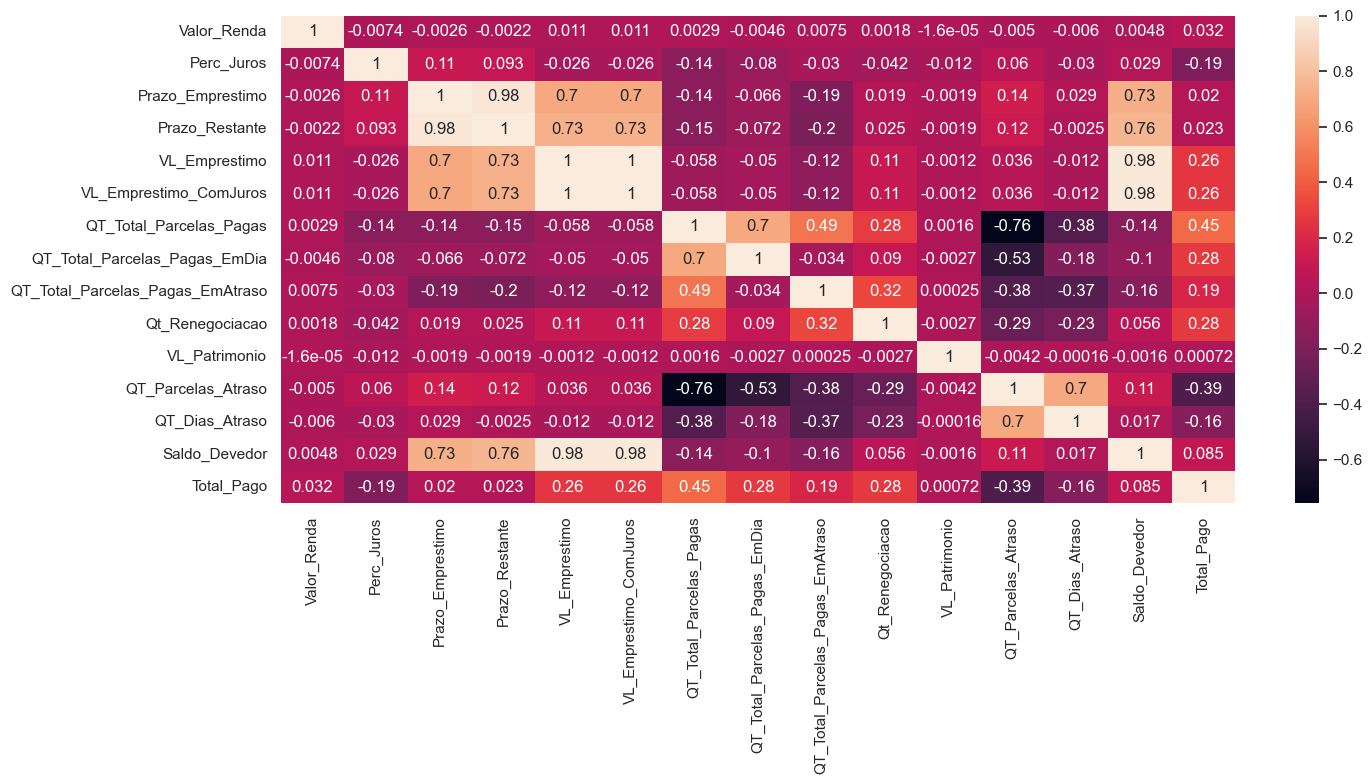

In [33]:
dados_var = dados[variaveis_numericas]
sns.set(rc={"figure.figsize": (15, 8)})
plot = sns.heatmap(dados_var.corr(), annot = True)
plot

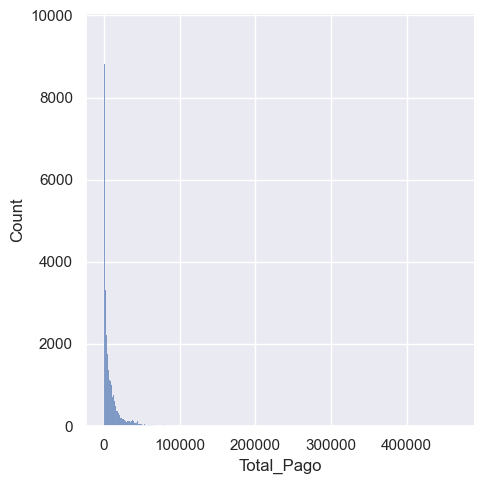

In [35]:
#Analisando o Total_Pago
sns.displot(dados["Total_Pago"])

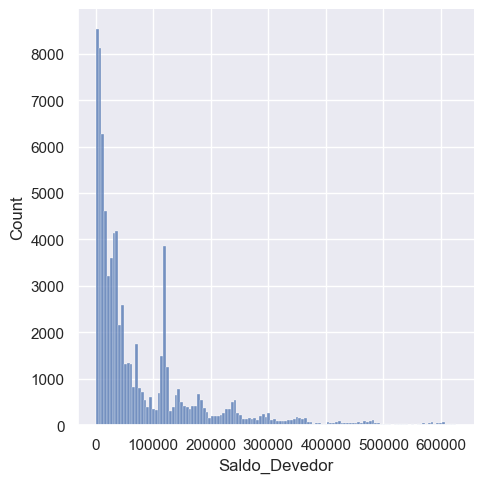

In [37]:
sns.displot(dados["Saldo_Devedor"])

Nos dois casos, existem muitos dados com o valor zero, o que gera essa distorção. Oque é uma característica do problema. 

In [43]:
dados["Valor_Renda"].describe()

count       80143.00
mean        29308.62
std       2748166.27
min             0.00
25%          2050.00
50%          3000.00
75%          5000.00
max     765000000.00
Name: Valor_Renda, dtype: float64

In [45]:
agrupar = dados.groupby(["Valor_Renda"]).size()
#agrupar

Como os dados de Valor de Renda possue varias rendas com um único dado e algumas rendas expecíficas com bastante dados, a melhor escolha é criar 
faixas de renda

In [47]:
#construi a faixa etária a partir dos quartis 
bins = [0, 2050, 3000, 5000, 765000000]
labels = ['Até 2050 de Renda', 'De 2050 até 3000 de Renda', 'De 3000 até 5000 de Renda', 'Acima de 5000 de Renda']
dados['Faixa_Renda'] = pd.cut(dados['Valor_Renda'], bins=bins, labels=labels)
dados.groupby(['Faixa_Renda']).size()

C:\Users\Darven Lima\AppData\Local\Temp\ipykernel_101812\2605222101.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dados.groupby(['Faixa_Renda']).size()


Faixa_Renda
Até 2050 de Renda            20043
De 2050 até 3000 de Renda    21322
De 3000 até 5000 de Renda    21105
Acima de 5000 de Renda       17664
dtype: int64

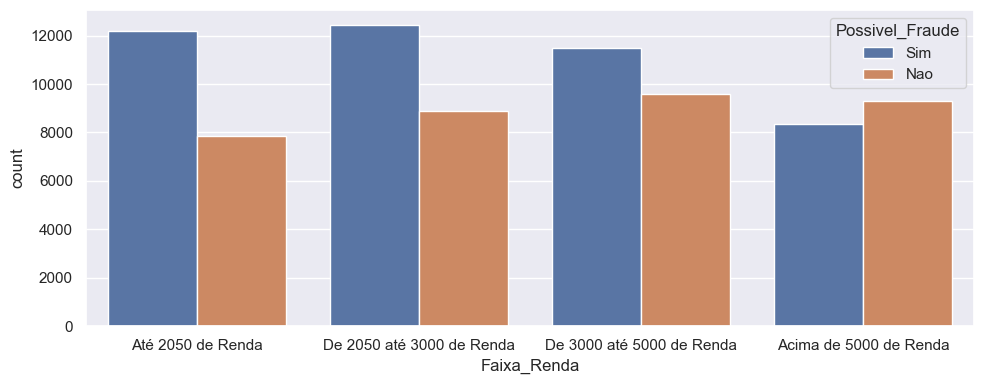

In [49]:
# Apenas para ajustar o tamanho dos gráficos
plt.rcParams["figure.figsize"] = [10.00, 4.00]
plt.rcParams["figure.autolayout"] = True

sns.countplot(data = dados, x = "Faixa_Renda", hue = "Possivel_Fraude")
plt.show()

In [55]:
dados["VL_Patrimonio"].describe()

count    80143.00
mean         1.45
std        355.10
min          0.00
25%          0.00
50%          0.00
75%          0.00
max     100000.00
Name: VL_Patrimonio, dtype: float64

In [58]:
agrupar = dados.groupby(["VL_Patrimonio"]).size()
agrupar

VL_Patrimonio
0.00         80135
1000.00          6
10000.00         1
100000.00        1
dtype: int64

Os dados VL_Patrimonio possuem praticamente todos os dados como zero, onde só 8 dados possuem valores diferentes, o que é um número pouco expressivo

In [66]:
dados.loc[dados["VL_Patrimonio"] == 100000]

,Contrato,Idade,Sexo,Valor_Renda,UF_Cliente,Perc_Juros,Prazo_Emprestimo,Data_Contratacao,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Escolaridade,Possui_Patrimonio,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago,Possivel_Fraude,Faixa_Etaria,Faixa_Renda
45363,322083682715,44,F,20000.00,SP,7.00,75,2022-10-18,64,50000.00,57500.00,13,0,2,0,CASADO (A),NaN,S,100000.00,0,468.00,44226.19,9303.27,Nao,De 37 até 46 Anos,Acima de 5000 de Renda


In [68]:
dados.loc[dados["VL_Patrimonio"] == 10000]

,Contrato,Idade,Sexo,Valor_Renda,UF_Cliente,Perc_Juros,Prazo_Emprestimo,Data_Contratacao,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Escolaridade,Possui_Patrimonio,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago,Possivel_Fraude,Faixa_Etaria,Faixa_Renda
55247,321959965715,46,M,8000.00,MA,21.00,55,2021-03-11,27,30000.00,34500.00,28,11,8,3,CASADO (A),Nenhum,S,10000.00,0,468.00,0.00,42484.14,Nao,De 37 até 46 Anos,Acima de 5000 de Renda


In [70]:
dados.loc[dados["VL_Patrimonio"] == 1000]

,Contrato,Idade,Sexo,Valor_Renda,UF_Cliente,Perc_Juros,Prazo_Emprestimo,Data_Contratacao,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Escolaridade,Possui_Patrimonio,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago,Possivel_Fraude,Faixa_Etaria,Faixa_Renda
4985,322050588715,48,M,10000.00,MG,16.00,50,2022-04-25,68,60000.00,69000.00,18,3,4,2,DIVORCIADO,Ensino Médio,S,1000.00,0,468.00,44957.06,25715.64,Nao,Acima de 46 Anos,Acima de 5000 de Renda
19438,322069789715,44,F,3500.00,MG,20.00,90,2022-08-05,76,30000.00,34500.00,15,11,2,2,CASADO (A),Ensino Superior,S,1000.00,0,468.00,30204.27,6238.84,Nao,De 37 até 46 Anos,De 3000 até 5000 de Renda
36043,322078990715,24,F,1830.00,GO,18.00,90,2022-09-22,77,70000.00,80500.00,11,0,6,3,CASADO (A),NaN,S,1000.00,1,11.00,31678.98,51726.14,Nao,Até 29 Anos,Até 2050 de Renda
44198,322085169715,24,F,1500.00,MG,21.00,40,2022-10-20,29,12000.00,13800.00,11,2,4,5,SOLTEIRO(A),Ensino Médio,S,1000.00,0,468.00,4618.82,10220.88,Nao,Até 29 Anos,Até 2050 de Renda
54727,322075143715,44,F,3500.00,MG,16.00,80,2022-09-01,74,60000.00,69000.00,12,3,0,5,CASADO (A),Ensino Superior,S,1000.00,0,468.00,36223.63,34058.95,Nao,De 37 até 46 Anos,De 3000 até 5000 de Renda
66516,322088198715,48,M,10000.00,GO,18.00,50,2022-11-25,39,50000.00,57500.00,10,6,3,6,CASADO (A),Ensino Fundamental,S,1000.00,0,468.00,29244.64,30897.64,Nao,Acima de 46 Anos,Acima de 5000 de Renda


Observando esses 8 valores é possível ver que nenhum possui possibilidade de fraude, o que poderia ser uma informação relevente onde quem possui 
VL_Patrimonio maior que zero tem menor probabilidade de fraude, mas pelo baixo número de dados dificulta corroborar essa informação.

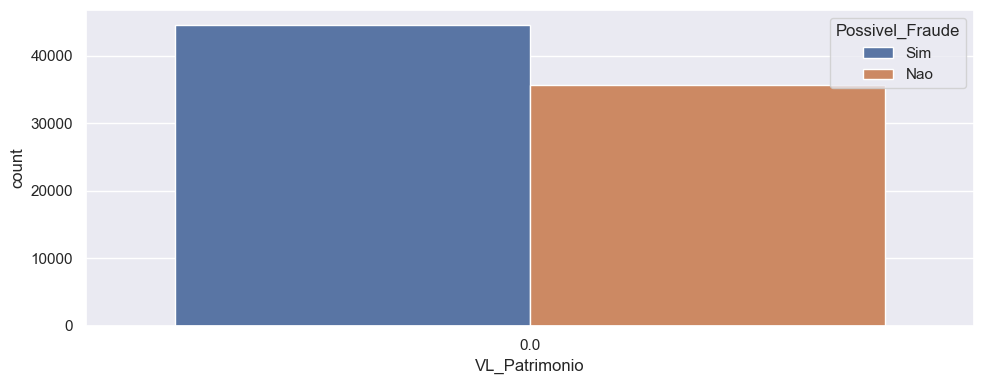

In [73]:
teste = dados.loc[dados["VL_Patrimonio"] == 0]
sns.countplot(data = teste, x = "VL_Patrimonio", hue = "Possivel_Fraude")
plt.show()

Avaliando a semelhança VL_Patrimonio e Possui_Patrimonio

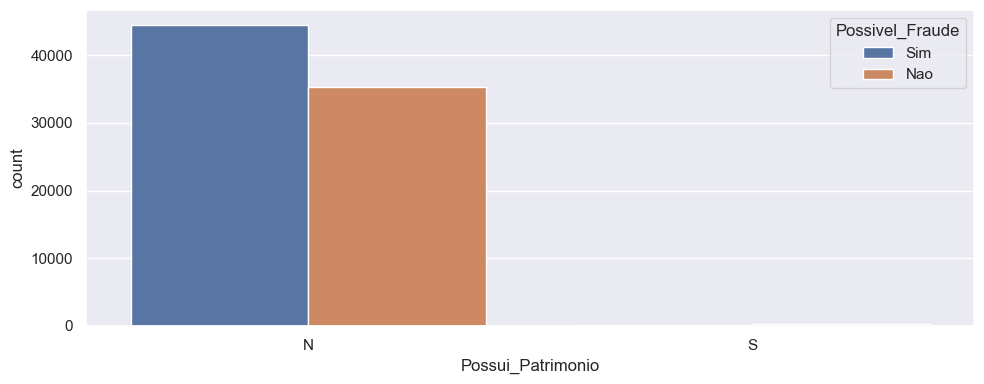

In [76]:
agrupar = dados.groupby(["Possui_Patrimonio"]).size()
agrupar
sns.countplot(data = dados, x = "Possui_Patrimonio", hue = "Possivel_Fraude")
plt.show()

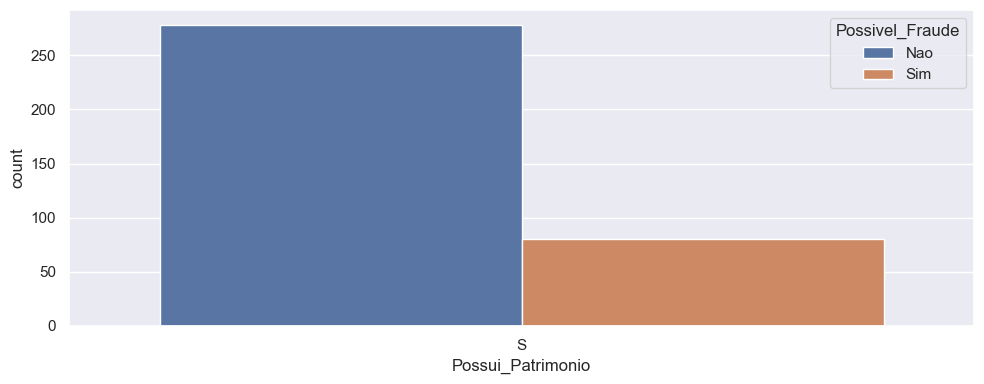

In [78]:
teste = dados.loc[dados["Possui_Patrimonio"] == 'S']
sns.countplot(data = teste, x = "Possui_Patrimonio", hue = "Possivel_Fraude")
plt.show()

E possível observer uma grande semelhança entre VL_Patrimonio e Possui_Patrimonio, onde a proporção entre os que não possuem patrimonio podem ou não 
Fraudar é semelhante as pessoas que tem VL_Patrimonio igual a 0. Já para as pessoas que possuem patrimonio, a probalibilidade de possível fraude é bem mais baixa, ocorroborando com os poucos dados de pessoas com VL_Patrimonio acima de zero.

Como aparentemente a correlação entre esses dois dados em relação a variável resposta é bem alta, é mais eficiente utilizar só a variável Possui_Patrimonio no modelo preditivo. 

In [81]:
# Apenas para ajustar o tamanho dos gráficos
plt.rcParams["figure.figsize"] = [10.00, 4.00]
plt.rcParams["figure.autolayout"] = True

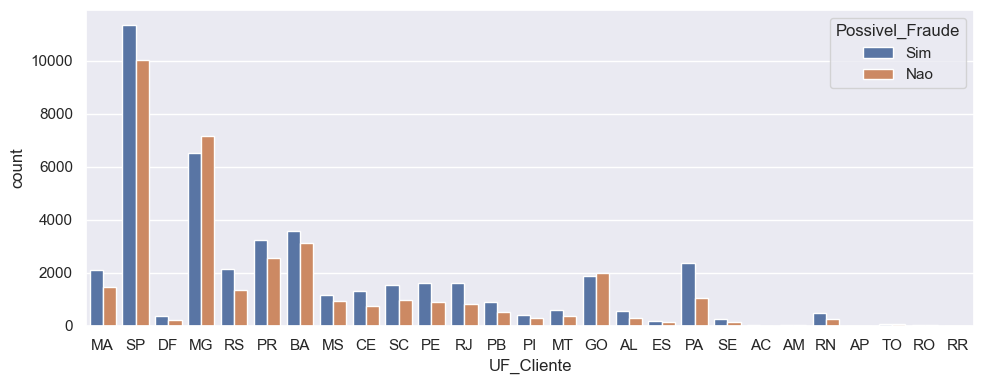

In [83]:
sns.countplot(data = dados, x = "UF_Cliente", hue = "Possivel_Fraude")
plt.show()

Pode-se observar que em certos estados que há uma menor probabilidade de fraude como MG e GO, já em outras regiões existe uma maior chance de fraude, como MA, SP, PA, RJ e PE. 

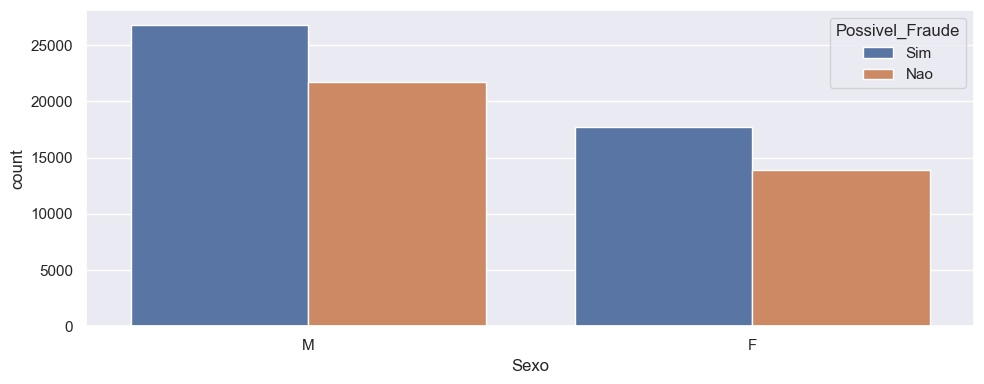

In [86]:
sns.countplot(data = dados, x = "Sexo", hue = "Possivel_Fraude")
plt.show()

os sexos não possuem uma grande discrepância, onde a proporção de fraudes é semelhante em ambos os sexos. 

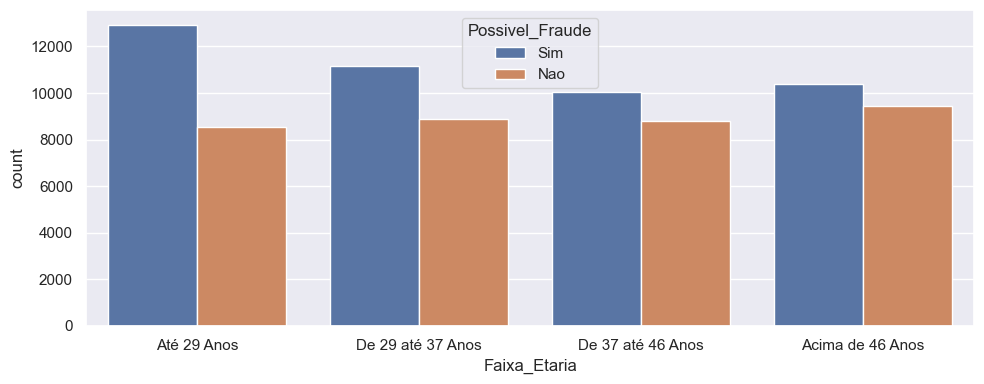

In [89]:
sns.countplot(data = dados, x = "Faixa_Etaria", hue = "Possivel_Fraude")
plt.show()

Pelo gráfico é possével notar que uma maior probabilidade de fraude em até 29 anos de idade, e que essa chance vai caindo aos poucos conforme a faixa 
etária aumenta.

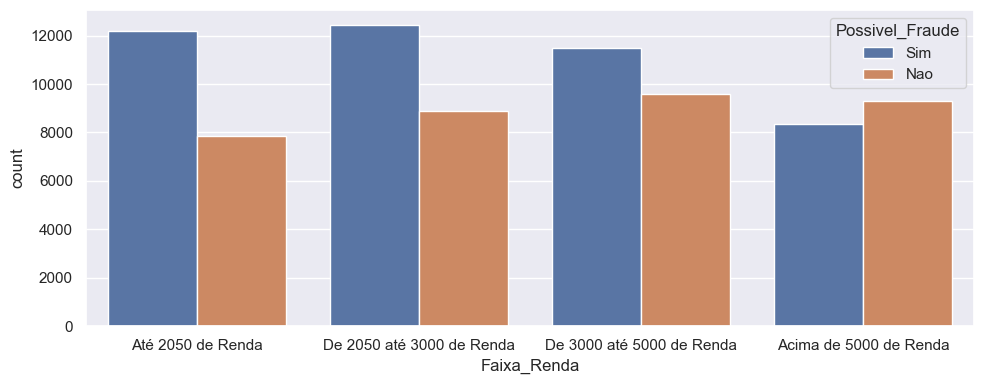

In [92]:
sns.countplot(data = dados, x = "Faixa_Renda", hue = "Possivel_Fraude")
plt.show()

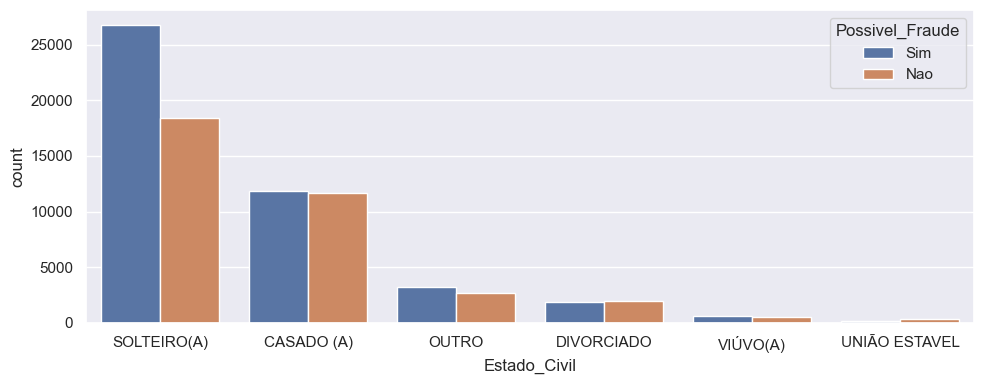

In [94]:
sns.countplot(data = dados, x = "Estado_Civil", hue = "Possivel_Fraude")
plt.show()

O probabilidade de um solteiro(a) fraudar é bem maior do que a dos outros estados civis. 

In [97]:
dados.columns

Index(['Contrato', 'Idade', 'Sexo', 'Valor_Renda', 'UF_Cliente', 'Perc_Juros',
       'Prazo_Emprestimo', 'Data_Contratacao', 'Prazo_Restante',
       'VL_Emprestimo', 'VL_Emprestimo_ComJuros', 'QT_Total_Parcelas_Pagas',
       'QT_Total_Parcelas_Pagas_EmDia', 'QT_Total_Parcelas_Pagas_EmAtraso',
       'Qt_Renegociacao', 'Estado_Civil', 'Escolaridade', 'Possui_Patrimonio',
       'VL_Patrimonio', 'QT_Parcelas_Atraso', 'QT_Dias_Atraso',
       'Saldo_Devedor', 'Total_Pago', 'Possivel_Fraude', 'Faixa_Etaria',
       'Faixa_Renda'],
      dtype='object')

In [99]:
#VL_Emprestimo_ComJuros, Saldo Devedor, QT_Dias_Atraso, Prazo_Restante -> alta correlação com outros dados.
columns = ['Sexo', 'UF_Cliente', 'Perc_Juros','Prazo_Restante', 
       'VL_Emprestimo',  'QT_Total_Parcelas_Pagas',
       'QT_Total_Parcelas_Pagas_EmDia', 'QT_Total_Parcelas_Pagas_EmAtraso',
       'Qt_Renegociacao', 'Estado_Civil','Possui_Patrimonio', 'QT_Parcelas_Atraso',  
       'Total_Pago','Faixa_Etaria', 'Faixa_Renda','Possivel_Fraude']

dados_model = pd.DataFrame(dados, columns=columns)
dados_model.head()

,Sexo,UF_Cliente,Perc_Juros,Prazo_Restante,VL_Emprestimo,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Possui_Patrimonio,QT_Parcelas_Atraso,Total_Pago,Faixa_Etaria,Faixa_Renda,Possivel_Fraude
0,M,MA,17.00,143,160000.00,2,1,1,2,SOLTEIRO(A),N,10,1617.36,De 37 até 46 Anos,De 3000 até 5000 de Renda,Sim
1,M,MA,20.00,0,14000.00,2,1,1,1,CASADO (A),N,26,1239.98,De 29 até 37 Anos,De 2050 até 3000 de Renda,Sim
2,F,SP,24.00,149,60000.00,4,1,0,1,CASADO (A),N,27,1346.64,De 29 até 37 Anos,De 2050 até 3000 de Renda,Sim
3,M,DF,19.00,159,180000.00,29,28,0,2,SOLTEIRO(A),N,2,22713.63,Até 29 Anos,De 2050 até 3000 de Renda,Nao
4,F,MG,22.00,94,30000.00,4,3,0,1,SOLTEIRO(A),N,6,900.80,Até 29 Anos,De 3000 até 5000 de Renda,Sim


In [101]:
dados_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80143 entries, 0 to 80142
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Sexo                              80143 non-null  object  
 1   UF_Cliente                        80143 non-null  object  
 2   Perc_Juros                        80143 non-null  float64 
 3   Prazo_Restante                    80143 non-null  int64   
 4   VL_Emprestimo                     80143 non-null  float64 
 5   QT_Total_Parcelas_Pagas           80143 non-null  int64   
 6   QT_Total_Parcelas_Pagas_EmDia     80143 non-null  int64   
 7   QT_Total_Parcelas_Pagas_EmAtraso  80143 non-null  int64   
 8   Qt_Renegociacao                   80143 non-null  int64   
 9   Estado_Civil                      80143 non-null  object  
 10  Possui_Patrimonio                 80143 non-null  object  
 11  QT_Parcelas_Atraso                80143 non-null  int6

In [103]:
variaveis_categoricas = []
for i in dados_model.columns[0:15].tolist():
        if dados_model.dtypes[i] == 'object' or dados_model.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i) 
variaveis_categoricas

['Sexo',
 'UF_Cliente',
 'Estado_Civil',
 'Possui_Patrimonio',
 'Faixa_Etaria',
 'Faixa_Renda']

In [105]:
# Cria o encoder e aplica OneHotEncoder
lb = LabelEncoder()

for var in variaveis_categoricas:
    dados_model[var] = lb.fit_transform(dados_model[var])

In [107]:
dados_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80143 entries, 0 to 80142
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sexo                              80143 non-null  int32  
 1   UF_Cliente                        80143 non-null  int32  
 2   Perc_Juros                        80143 non-null  float64
 3   Prazo_Restante                    80143 non-null  int64  
 4   VL_Emprestimo                     80143 non-null  float64
 5   QT_Total_Parcelas_Pagas           80143 non-null  int64  
 6   QT_Total_Parcelas_Pagas_EmDia     80143 non-null  int64  
 7   QT_Total_Parcelas_Pagas_EmAtraso  80143 non-null  int64  
 8   Qt_Renegociacao                   80143 non-null  int64  
 9   Estado_Civil                      80143 non-null  int32  
 10  Possui_Patrimonio                 80143 non-null  int32  
 11  QT_Parcelas_Atraso                80143 non-null  int64  
 12  Tota

In [109]:
# Visualiznado a quantidade da variavel target para balanceamento
variavel_target = dados_model.Possivel_Fraude.value_counts()
variavel_target

Possivel_Fraude
Sim    44511
Nao    35632
Name: count, dtype: int64

In [111]:
#Separar variaveis preditoras e target
PREDITORAS = dados_model.iloc[:, 0:15]  
TARGET = dados_model.iloc[:, 15] 

In [113]:
PREDITORAS.head()

,Sexo,UF_Cliente,Perc_Juros,Prazo_Restante,VL_Emprestimo,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Possui_Patrimonio,QT_Parcelas_Atraso,Total_Pago,Faixa_Etaria,Faixa_Renda
0,1,9,17.00,143,160000.00,2,1,1,2,3,0,10,1617.36,3,3
1,1,9,20.00,0,14000.00,2,1,1,1,0,0,26,1239.98,2,2
2,0,25,24.00,149,60000.00,4,1,0,1,0,0,27,1346.64,2,2
3,1,6,19.00,159,180000.00,29,28,0,2,3,0,2,22713.63,1,2
4,0,10,22.00,94,30000.00,4,3,0,1,3,0,6,900.80,1,3


In [115]:
TARGET.head()

0    Sim
1    Sim
2    Sim
3    Nao
4    Sim
Name: Possivel_Fraude, dtype: object

In [117]:
# Seed para reproduzir o mesmo resultado
seed = 100

# Cria o balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplica o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)

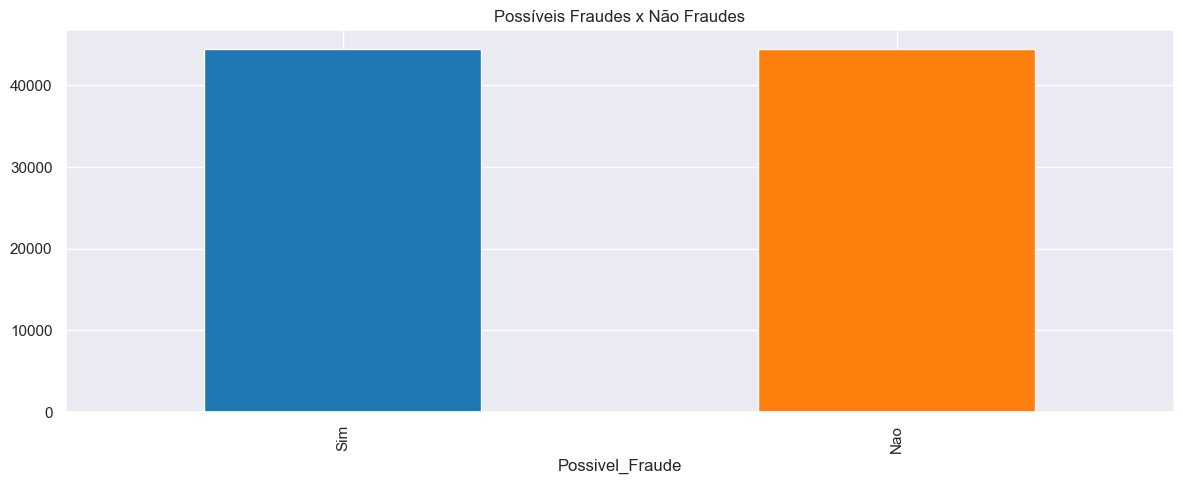

In [119]:
# Visualizando o balanceamento da variável TARGET
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
TARGET_RES.value_counts().plot(kind='bar', title='Possíveis Fraudes x Não Fraudes',color = ['#1F77B4', '#FF7F0E']);

In [121]:
# Quantidade de registros antes do balanceamento
PREDITORAS.shape

(80143, 15)

In [123]:
# Quantidade de registros após do balanceamento
PREDITORAS_RES.shape

(89022, 15)

In [125]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size = 0.3, random_state = 42)

In [127]:
# Normalização das Variáveis
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_treino)
X_teste_normalizados = Normalizador.transform(X_teste)

In [129]:
X_treino_normalizados

array([[1.        , 0.15384615, 0.52380952, ..., 0.03984871, 0.66666667,
        0.75      ],
       [0.        , 0.30769231, 0.52380952, ..., 0.04649224, 1.        ,
        0.75      ],
       [1.        , 0.34615385, 0.38095238, ..., 0.05871447, 0.        ,
        0.        ],
       ...,
       [1.        , 0.96153846, 0.52380952, ..., 0.01102209, 0.66666667,
        0.75      ],
       [1.        , 0.19230769, 0.52380952, ..., 0.06936733, 1.        ,
        0.5       ],
       [0.        , 0.15384615, 0.61904762, ..., 0.00189364, 0.66666667,
        0.25      ]])

In [131]:
# Construtor do Modelo
randomForest = RandomForestClassifier()

In [133]:
# Parametros default
randomForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [135]:
# Valores para o grid de hiperparametros
n_estimators = np.array([100,200,300])
max_depth = np.array([10,20])
criterion = np.array(["gini", "entropy"])
max_features = np.array(["sqrt", "log2", None])
min_samples_split = np.array([2,5])
min_samples_leaf = np.array([2,3])


# Grid de hiperparâmetros
grid_parametros = dict(n_estimators = n_estimators,
                       max_depth = max_depth,
                       criterion = criterion,
                       max_features = max_features,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
# Criando o modelo com o Grid de Hiperparametros
randomForest = GridSearchCV(randomForest, param_grid, cv = 3)
# Treinando os modelos
#inicio = time.time()
randomForest.fit(X_treino_normalizados, Y_treino)
#fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_rf = pd.DataFrame(randomForest.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {randomForest.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {randomForest.best_params_}")
#print("")
#print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Numero de treinamentos realizados: ", treinos_rf.shape[0])

C:\Users\Darven Lima\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Darven Lima\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Darven Lima\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Darven Lima\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Darven Li

Acurácia em Treinamento: 99.13%

Hiperparâmetros Ideais: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}

Numero de treinamentos realizados:  60


In [137]:
# Criando o classificador com Random Forest
clf_forest = RandomForestClassifier(n_estimators  = 200, criterion = 'gini', max_depth = 8, max_features = 'log2')

# Construção do modelo
clf_forest = clf_forest.fit(X_treino_normalizados, Y_treino)


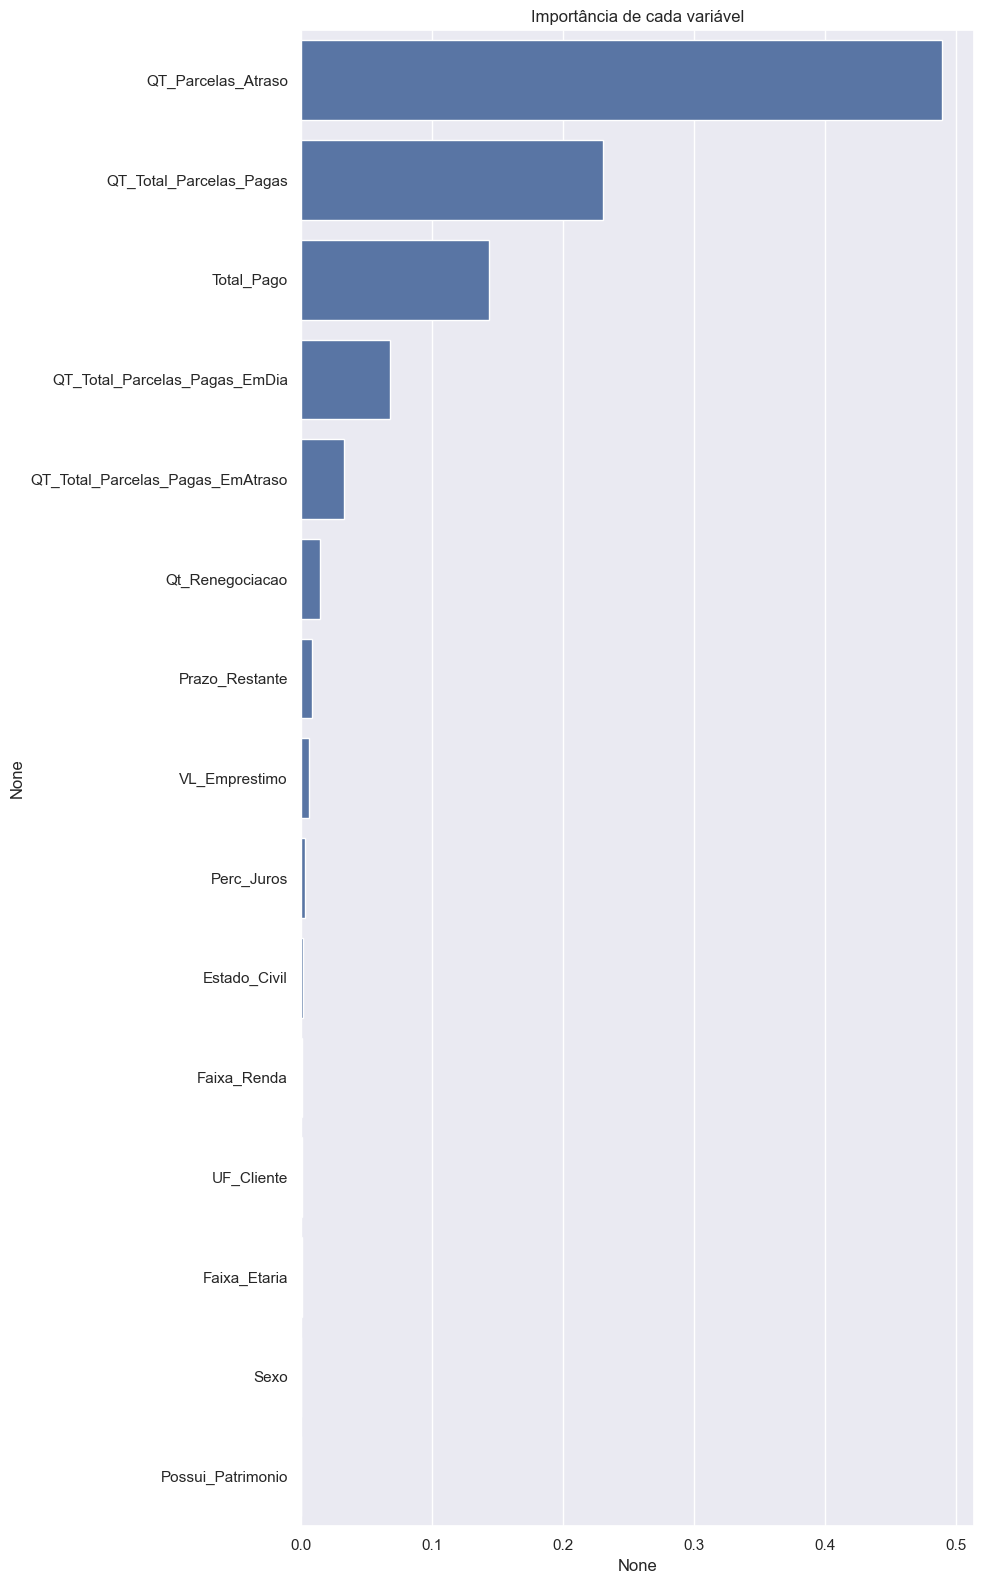

In [140]:
plt.rcParams["figure.figsize"] = [10.00, 16.00]
plt.rcParams["figure.autolayout"] = True

importances = pd.Series(data=clf_forest.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()

In [142]:
# Visualizando o percentual de importancia de cada variável
importances.sort_values(ascending = False)

QT_Parcelas_Atraso                 0.49
QT_Total_Parcelas_Pagas            0.23
Total_Pago                         0.14
QT_Total_Parcelas_Pagas_EmDia      0.07
QT_Total_Parcelas_Pagas_EmAtraso   0.03
Qt_Renegociacao                    0.01
Prazo_Restante                     0.01
VL_Emprestimo                      0.01
Perc_Juros                         0.00
Estado_Civil                       0.00
Faixa_Renda                        0.00
UF_Cliente                         0.00
Faixa_Etaria                       0.00
Sexo                               0.00
Possui_Patrimonio                  0.00
dtype: float64

In [144]:
# Estamos apenas "simulando" os dados de teste
scores = clf_forest.score(X_treino_normalizados,Y_treino)
scores

0.992955147235818

In [146]:
scores = clf_forest.score(X_teste_normalizados,Y_teste)
scores

0.9895158572658853

In [148]:
PREDITORAS_otimizado = PREDITORAS_RES[['QT_Parcelas_Atraso','QT_Total_Parcelas_Pagas','Total_Pago']]
#dados_model.head()
PREDITORAS_otimizado.shape

(89022, 3)

In [150]:
X_treino2, X_teste2, Y_treino2, Y_teste2 = train_test_split(PREDITORAS_otimizado, TARGET_RES, test_size = 0.3, random_state = 42)
Normalizador = MinMaxScaler()
X_treino_normalizados2 = Normalizador.fit_transform(X_treino)
X_teste_normalizados2 = Normalizador.transform(X_teste)

In [152]:
clf_forest = clf_forest.fit(X_treino_normalizados2, Y_treino2)
scores = clf_forest.score(X_treino_normalizados2,Y_treino2)
scores

0.9929872422370216

In [153]:
scores = clf_forest.score(X_teste_normalizados2,Y_teste2)
scores

0.9897779608342382

In [154]:
knn = KNeighborsClassifier()

In [203]:
# Valores para o grid de hiperparametros
n_neighbors = np.array([3,4,5,6,7])
algorithm = np.array(['auto', 'ball_tree', 'kd_tree', 'brute'])
leaf_size = np.array([30,31,32])
metric =  np.array(['minkowski','euclidean'])


# Grid de hiperparâmetros
grid_parametros = {'n_neighbors' : [3,4,5,6,7]}

knn = GridSearchCV(knn, grid_parametros, cv = 3)

# Treinando os modelos
#inicio = time.time()
knn.fit(X_treino_normalizados, Y_treino)
#fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_knn = pd.DataFrame(knn.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {knn.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {knn.best_params_}")
print("")
#print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Numero de treinamentos realizados: ", treinos_knn.shape[0])

Acurácia em Treinamento: 97.77%

Hiperparâmetros Ideais: {'n_neighbors': 7}


Numero de treinamentos realizados:  5


In [158]:
clf = MLPClassifier(max_iter = 500, verbose = True, tol=0.0000100)

clf.fit(X_treino_normalizados, Y_treino)

Iteration 1, loss = 0.28433441
Iteration 2, loss = 0.08621897
Iteration 3, loss = 0.06228102
Iteration 4, loss = 0.05218566
Iteration 5, loss = 0.04703295
Iteration 6, loss = 0.04359101
Iteration 7, loss = 0.04138035
Iteration 8, loss = 0.03975286
Iteration 9, loss = 0.03821081
Iteration 10, loss = 0.03662806
Iteration 11, loss = 0.03530264
Iteration 12, loss = 0.03400145
Iteration 13, loss = 0.03271123
Iteration 14, loss = 0.03173094
Iteration 15, loss = 0.03064133
Iteration 16, loss = 0.02979891
Iteration 17, loss = 0.02903624
Iteration 18, loss = 0.02853260
Iteration 19, loss = 0.02800766
Iteration 20, loss = 0.02758497
Iteration 21, loss = 0.02759296
Iteration 22, loss = 0.02688960
Iteration 23, loss = 0.02674925
Iteration 24, loss = 0.02644111
Iteration 25, loss = 0.02624021
Iteration 26, loss = 0.02621351
Iteration 27, loss = 0.02593671
Iteration 28, loss = 0.02580148
Iteration 29, loss = 0.02572024
Iteration 30, loss = 0.02561938
Iteration 31, loss = 0.02563185
Iteration 32, los

MLPClassifier(max_iter=500, tol=1e-05, verbose=True)

In [160]:
predicao = clf.predict(X_teste_normalizados)

In [162]:
accuracy_score(Y_teste, predicao)

0.9910884786760026

In [159]:
clf.fit(X_treino_normalizados2,Y_treino2)

Iteration 1, loss = 0.29169313
Iteration 2, loss = 0.09066697
Iteration 3, loss = 0.06655906
Iteration 4, loss = 0.05547413
Iteration 5, loss = 0.04931551
Iteration 6, loss = 0.04576209
Iteration 7, loss = 0.04328535
Iteration 8, loss = 0.04097825
Iteration 9, loss = 0.03911158
Iteration 10, loss = 0.03657994
Iteration 11, loss = 0.03467535
Iteration 12, loss = 0.03279817
Iteration 13, loss = 0.03144852
Iteration 14, loss = 0.03010440
Iteration 15, loss = 0.02900241
Iteration 16, loss = 0.02827134
Iteration 17, loss = 0.02766316
Iteration 18, loss = 0.02726447
Iteration 19, loss = 0.02703577
Iteration 20, loss = 0.02650252
Iteration 21, loss = 0.02635375
Iteration 22, loss = 0.02599744
Iteration 23, loss = 0.02579912
Iteration 24, loss = 0.02581373
Iteration 25, loss = 0.02549485
Iteration 26, loss = 0.02543002
Iteration 27, loss = 0.02522751
Iteration 28, loss = 0.02539010
Iteration 29, loss = 0.02536885
Iteration 30, loss = 0.02522529
Iteration 31, loss = 0.02504701
Iteration 32, los

MLPClassifier(max_iter=500, tol=1e-05, verbose=True)

In [164]:
predicao2 = clf.predict(X_teste_normalizados2)
accuracy_score(Y_teste2, predicao2)

0.9910884786760026

In [168]:
clf2 = MLPClassifier(max_iter = 500, verbose = True, tol=0.0000100, solver = 'adam', activation = 'relu', hidden_layer_sizes = (5,5))
clf2.fit(X_treino_normalizados2,Y_treino2)


Iteration 1, loss = 0.59468920
Iteration 2, loss = 0.28883376
Iteration 3, loss = 0.19768614
Iteration 4, loss = 0.15710386
Iteration 5, loss = 0.13046116
Iteration 6, loss = 0.11071465
Iteration 7, loss = 0.09549648
Iteration 8, loss = 0.08374658
Iteration 9, loss = 0.07481717
Iteration 10, loss = 0.06781484
Iteration 11, loss = 0.06231229
Iteration 12, loss = 0.05776010
Iteration 13, loss = 0.05404337
Iteration 14, loss = 0.05102717
Iteration 15, loss = 0.04843370
Iteration 16, loss = 0.04601959
Iteration 17, loss = 0.04405544
Iteration 18, loss = 0.04230998
Iteration 19, loss = 0.04087249
Iteration 20, loss = 0.03944778
Iteration 21, loss = 0.03816163
Iteration 22, loss = 0.03703616
Iteration 23, loss = 0.03616426
Iteration 24, loss = 0.03530908
Iteration 25, loss = 0.03448489
Iteration 26, loss = 0.03364509
Iteration 27, loss = 0.03316724
Iteration 28, loss = 0.03254217
Iteration 29, loss = 0.03209008
Iteration 30, loss = 0.03163256
Iteration 31, loss = 0.03112943
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(5, 5), max_iter=500, tol=1e-05, verbose=True)

In [170]:
predicao3 = clf2.predict(X_teste_normalizados2)
accuracy_score(Y_teste2, predicao3)

0.98929119706444

[[13180   112]
 [  126 13289]]


<Axes: >

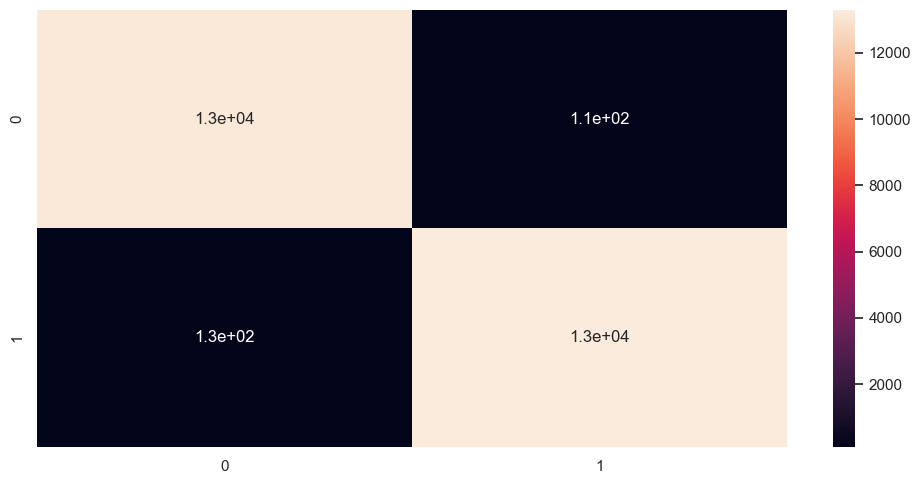

In [172]:
from sklearn.metrics import confusion_matrix
matrix_confusao = confusion_matrix(Y_teste2, predicao2)
print(matrix_confusao)
plt.figure(figsize = (10,5))
sns.heatmap(matrix_confusao, annot = True)

0.9897779608342382
[[13092   200]
 [   73 13342]]


<Axes: >

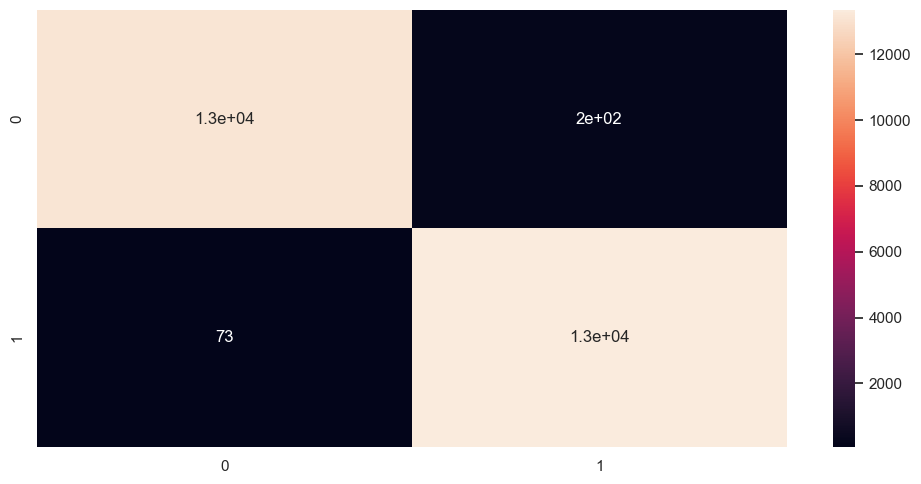

In [174]:
predicao_forest = clf_forest.predict(X_teste_normalizados2)
matrix_confusao = confusion_matrix(Y_teste2, predicao_forest)
print(accuracy_score(Y_teste2, predicao_forest))
print(matrix_confusao)
plt.figure(figsize = (10,5))
sns.heatmap(matrix_confusao, annot = True)

In [190]:
Y_teste_dataframe = pd.DataFrame( {'Y_teste':Y_teste2.values})
Y_teste_dataframe.groupby('Y_teste').size()
#Y_teste_dataframe

Y_teste
Nao    13292
Sim    13415
dtype: int64

Com a analise da matriz de confusão, mostra que a rede neural é mais vatajosa para esse problema mesmo a acuracia da Random Florest sendo semenhante, pois para o modelo de fraude é mais relevante ter um menor número de falsos negativos (situação onde o modelo erra em dizer que a pessoa não é uma possível fraudadora mas na realidade ela é uma possível fraudadora). Porque para a empresa cair em uma fraude gera maior perda econômica.  